# Convert ICON data to Healpix

If you are interested in converting ICON data to Healpix, you can follow this example:

In [1]:
import pathlib

import numpy as np
import pandas as pd
import xarray as xr

import healpix
import easygems.healpix as egh
import easygems.remap as egr


In [2]:
data_path = pathlib.Path("/work/scratch-pw2/wkjones/hamlite")
invariants_path = (data_path / "invariants")

In [4]:
icon_grid_r2b9 = xr.open_dataset(invariants_path / 'icon_grid_G.nc')
icon_grid_r2b9

<xarray.Dataset> Size: 20GB
Dimensions:                         (cell: 20971520, nv: 3, vertex: 10485762,
                                     ne: 6, edge: 31457280, no: 4, nc: 2,
                                     max_stored_decompositions: 4, two_grf: 2,
                                     cell_grf: 14, max_chdom: 1, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (cell) float64 168MB ...
    clat                            (cell) float64 168MB ...
    vlon                            (vertex) float64 84MB ...
    vlat                            (vertex) float64 84MB ...
    elon                            (edge) float64 252MB ...
    elat                            (edge) float64 252MB ...
Dimensions without coordinates: cell, nv, vertex, ne, edge, no, nc,
                                max_stored_decompositions, two_grf, cell_grf,
                                max_chdom, edge_grf, vert_grf
Data variables: (12/91)
    clon_vertices                   (cell, nv) float64 503MB ...
    clat_vertices                   (cell, nv) float64 503MB ...
    vlon_vertices                   (vertex, ne) float64 503MB ...
    vlat_vertices                   (vertex, ne) float64 503MB ...
    elon_vertices                   (edge, no) float64 1GB ...
    elat_vertices                   (edge, no) float64 1GB ...
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 252MB ...
    edge_dual_normal_cartesian_y    (edge) float64 252MB ...
    edge_dual_normal_cartesian_z    (edge) float64 252MB ...
    cell_circumcenter_cartesian_x   (cell) float64 168MB ...
    cell_circumcenter_cartesian_y   (cell) float64 168MB ...
    cell_circumcenter_cartesian_z   (cell) float64 168MB ...
Attributes: (12/43)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@git.mpimet.mpg.de:GridGenerator.git
    revision:                 d00fcac1f61fa16c686bfe51d1d8eddd09296cb5
    date:                     20180529 at 222250
    user_name:                Rene Redler (m300083)
    ...                       ...
    topography:               modified SRTM30
    subcentre:                1
    number_of_grid_used:      15
    history:                  Thu Aug 16 11:05:44 2018: ncatted -O -a ICON_gr...
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    NCO:                      netCDF Operators version 4.7.5 (Homepage = http...

The ICON r2b9 grid is closest in resolution to zoom level 10 of healpix, so we consider this the target for regridding:

In [5]:
order = zoom = 10
nside = healpix.order2nside(order)
npix = healpix.nside2npix(nside)

In [6]:
weights_file = invariants_path / f'r2b9_to_healpix_z{zoom}_weights.nc'

In [7]:
weights_file.exists()

True

I've precomputed the regridding weights, but the following cell demonstrates how they are generated (following https://easy.gems.dkrz.de/Processing/datasets/remapping.html)

In [8]:
if not weights_file.exists():
    print("Generating weights file, warning, slow!")
    # Create periodic lat/lon arrays for the ICON grid
    r2b9_lon_periodic = np.degrees(np.concatenate([icon_grid_r2b9.clon - (2*np.pi), icon_grid_r2b9.clon, icon_grid_r2b9.clon + (2*np.pi)]))
    r2b9_lat_periodic = np.degrees(np.concatenate([icon_grid_r2b9.clat, icon_grid_r2b9.clat, icon_grid_r2b9.clat]))

    # Find healpix grid locations for zoom level 10
    hp_lon, hp_lat = healpix.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width
    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)

    # Compute weights
    weights = egr.compute_weights_delaunay(
        points=(r2b9_lon_periodic, r2b9_lat_periodic),
        xi=(hp_lon, hp_lat)
    )
    
    # Remap the source indices back to their valid range
    weights = weights.assign(src_idx=weights.src_idx % icon_grid_r2b9.clat.size)

    weights.to_netcdf(invariants_path / f'r2b9_to_healpix_z{zoom}_weights.nc')

Load precomputed weights:

In [10]:
weights = xr.open_dataset(invariants_path / "r2b9_to_healpix_z10_weights.nc").load()

## Test regridding from ICON to healpix

In [11]:
atm_2d_standard = xr.open_dataset(data_path / "run_20200125T000000-20200129T235920" / "r2b9_lite_0924g_atm_2d_std_ml_20200125T000000Z.nc")
atm_2d_standard

<xarray.Dataset> Size: 75GB
Dimensions:   (time: 23, height: 1, height_2: 1, lev: 1, ncells: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 184B 2020-01-25T01:00:00 ... 2020-01-25T2...
  * height    (height) float64 8B 10.0
  * height_2  (height_2) float64 8B 2.0
  * lev       (lev) float64 8B 0.0
Dimensions without coordinates: ncells
Data variables: (12/39)
    ps        (time, ncells) float32 2GB ...
    psl       (time, ncells) float32 2GB ...
    rsdt      (time, ncells) float32 2GB ...
    rsut      (time, ncells) float32 2GB ...
    rsutcs    (time, ncells) float32 2GB ...
    rlut      (time, ncells) float32 2GB ...
    ...        ...
    sfcwind   (time, height, ncells) float32 2GB ...
    uas       (time, height, ncells) float32 2GB ...
    vas       (time, height, ncells) float32 2GB ...
    tas       (time, height_2, ncells) float32 2GB ...
    dew2      (time, height_2, ncells) float32 2GB ...
    ptp       (time, lev, ncells) float32 2GB ...
Attributes:
    CDI:                  Climate Data Interface version 2.2.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@4ce6927f298ef...
    history:              ./icon at 20240923 015506
    references:           see MPIM/DWD publications
    comment:              Philipp Weiss (b381642) on l30185 (Linux 4.18.0-477...

Let's try remapping surface air temperature to healpix (warning, slow):

In [12]:
# Use xr.apply_ufunc to apply it across the whole time dimension
tas_remap = xr.apply_ufunc(
    egr.apply_weights,
    atm_2d_standard.tas.squeeze(drop=True),
    kwargs=weights,
    keep_attrs=True,
    input_core_dims=[["ncells"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
tas_remap

<xarray.DataArray 'tas' (time: 23, cell: 12582912)> Size: 1GB
array([[300.26123, 300.1999 , 300.24396, ..., 301.0143 , 300.90186,
        300.99597],
       [299.78598, 299.91757, 299.855  , ..., 300.90448, 300.9358 ,
        300.97763],
       [300.2647 , 300.25717, 300.1664 , ..., 300.77353, 300.81647,
        300.75037],
       ...,
       [300.36835, 300.30234, 300.29193, ..., 301.0361 , 300.9209 ,
        300.79913],
       [300.06912, 300.15247, 300.07736, ..., 301.02057, 300.91245,
        301.04242],
       [300.35474, 300.2751 , 300.33105, ..., 301.0417 , 301.03098,
        301.03128]], shape=(23, 12582912), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 184B 2020-01-25T01:00:00 ... 2020-01-25T23...
Dimensions without coordinates: cell
Attributes:
    standard_name:                tas
    long_name:                    temperature in 2m
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

We can now add the healpix CRS coordinate:

In [13]:
tas_remap = tas_remap.assign_coords(crs=xr.DataArray(0, attrs=dict(grid_mapping="healpix", healpix_nside=nside, healpix_order="nest")))

And plot using easygems:

<Figure size 640x480 with 0 Axes>

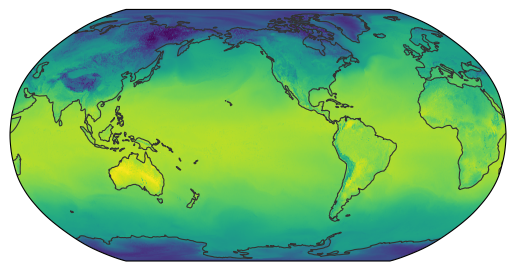

In [15]:
egh.healpix_show(tas_remap[0])

## Remapping to a lower zoom level

We can easily remap the dataset to a lower zoom level using the `coarsen` property of `xarray`:

<Figure size 640x480 with 0 Axes>

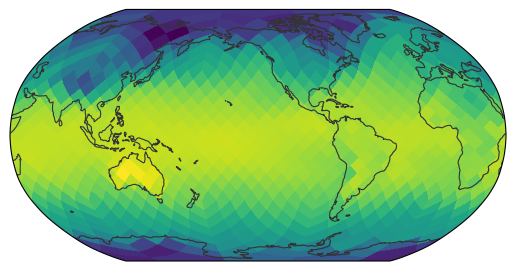

In [16]:
target_zoom = 3

tas_zoom = tas_remap.coarsen(cell=4**(zoom-target_zoom)).mean()

egh.healpix_show(tas_zoom[0])

This should be conservative:

In [19]:
tas_remap.mean()

<xarray.DataArray 'tas' ()> Size: 4B
array(286.28427, dtype=float32)
Coordinates:
    crs      int64 8B 0

In [20]:
tas_zoom.mean()

<xarray.DataArray 'tas' ()> Size: 4B
array(286.28677, dtype=float32)
Coordinates:
    crs      int64 8B 0